# **Housing Market and Venues in Austin,TX**
--------

## **1. Introduction**

#### **1.1. Description & Disscusion of the Background**
Austin is the capital city of the U.S. state of Texas, as well as the seat and largest city of Travis County, with portions extending into Hays and Williamson counties. Incorporated on December 27, 1839, it is the 11th-most populous city in the United States, the fourth-most-populous city in Texas, and the second-most-populous state capital city (after Phoenix, Arizona). It was also the fastest growing large city in the United States in 2015 and 2016.
At the 2000 United States Census, there were 656,562 people, 265,649 households, and 141,590 families residing in the city (roughly comparable in size to San Francisco, Leeds, UK; and Ottawa, Ontario, Canada). The population density was 2,610.4 inhabitants per square mile (1,007.9/km2). There were 276,842 housing units at an average density of 1,100.7 per square mile (425.0/km2).

Austin is considered to be a major center for high tech. Thousands of graduates each year from the engineering and computer science programs at the University of Texas at Austin provide a steady source of employees that help to fuel Austin's technology and defense industry sectors. The region's rapid growth has led Forbes to rank the Austin metropolitan area number one among all big cities for jobs for 2012 in their annual survey and WSJ Marketwatch to rank the area number one for growing businesses. The proliferation of technology companies has led to the region's nickname, "Silicon Hills," and spurred development that greatly expanded the city.[1]

Austin’s population has been growing at an average rate of 55,500 people every year or 155 people every day since 2010. The biggest source of new residents for the city come from other parts of Texas, followed by California, Florida, New York, and Illinois. The city also leads in job creation, Economists at PriceWaterhouseCoopers expect the city to create more jobs than any other metropolitan area in the country in 2020, despite the pandemic.[2] 

When we think of it by the investor, we expect from them to prefer the neighborhoods where there is a lower real estate cost and the type of business they want to start is less intense. If we think of the city residents, they may want to choose the regions where real estate values are lower. At the same time, they may want to choose the neighborhood according to the social places density. However, it is difficult to obtain information that will guide investors in this direction.

When we consider all these problems, we can create a map and information chart where the real estate index is placed on Austin and each district is clustered according to the venue density.

#### **1.2. Data Description**

We'll be using the following sources to get our required data from:

1. Foursquare API to get the most common venues of given neighborhood of Austin
2. An excel file containing a list of Austin neighborhoods and the associated median home prices downloaded from the following zillow.
3. A json file from the Official City of Austin Data portal containing a list of neighborhoods and their planning areas.

## **2. Methodology**

**2.1 **Data import and pre-processing**

In [3]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.7.0 --yes
import folium # map rendering library

Let us now import the Austin neighborhood boundaries geojson file into a geopandas dataframe

In [4]:
#!conda install -c conda-forge geopandas
import geopandas as gpd
df = gpd.read_file('Boundaries_ Austin Neighborhood Planning Areas.geojson')
df

planning_a     shape_area                label     shape_leng  \
0             ALLANDALE  65792689.5531            Allandale  42253.1072105   
1          BARTON HILLS  88901714.7947         Barton Hills  48353.9339254   
2         BOULDIN CREEK  33258999.9494        Bouldin Creek  25667.3403756   
3             BRENTWOOD   44207756.068            Brentwood  29612.4036976   
4   CENTRAL EAST AUSTIN  26970983.8606  Central East Austin  22198.5298969   
..                  ...            ...                  ...            ...   
60             WESTGATE  23392745.0704             Westgate  20150.5379802   
61         WINDSOR PARK  66436272.1129         Windsor Park  40527.3643673   
62         WINDSOR ROAD  23738027.5716         Windsor Road  21571.6474345   
63               WOOTEN  26731350.0427               Wooten  23584.9457018   
64               ZILKER  32343953.1211               Zilker   28074.142472   

   _feature_i                                           geometry  
0         1.0  MULTIPOLYGON (((-97.73974 30.32808, -97.73962 ...  
1         2.0  MULTIPOLYGON (((-97.79627 30.23398, -97.79767 ...  
2         3.0  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...  
3         4.0  MULTIPOLYGON (((-97.73692 30.31449, -97.73757 ...  
4         5.0  MULTIPOLYGON (((-97.71925 30.27073, -97.71903 ...  
..        ...                                                ...  
60       60.0  MULTIPOLYGON (((-97.78846 30.22972, -97.78938 ...  
61       62.0  MULTIPOLYGON (((-97.67076 30.30853, -97.67203 ...  
62       63.0  MULTIPOLYGON (((-97.74801 30.30720, -97.74754 ...  
63       64.0  MULTIPOLYGON (((-97.71301 30.34841, -97.71270 ...  
64       65.0  MULTIPOLYGON (((-97.76899 30.24601, -97.76918 ...  

[65 rows x 6 columns]

We need to then extract the centroid from the multipolygon for each neighborhood to arrive at unique coordinates

In [5]:
#Find the center point
df['Center_point'] = df['geometry'].centroid
#Extract lat and lon from the centerpoint
df["lat"] = df.centroid.y
df["long"] = df.centroid.x
df.head()

planning_a     shape_area                label     shape_leng  \
0            ALLANDALE  65792689.5531            Allandale  42253.1072105   
1         BARTON HILLS  88901714.7947         Barton Hills  48353.9339254   
2        BOULDIN CREEK  33258999.9494        Bouldin Creek  25667.3403756   
3            BRENTWOOD   44207756.068            Brentwood  29612.4036976   
4  CENTRAL EAST AUSTIN  26970983.8606  Central East Austin  22198.5298969   

  _feature_i                                           geometry  \
0        1.0  MULTIPOLYGON (((-97.73974 30.32808, -97.73962 ...   
1        2.0  MULTIPOLYGON (((-97.79627 30.23398, -97.79767 ...   
2        3.0  MULTIPOLYGON (((-97.75962 30.24211, -97.76031 ...   
3        4.0  MULTIPOLYGON (((-97.73692 30.31449, -97.73757 ...   
4        5.0  MULTIPOLYGON (((-97.71925 30.27073, -97.71903 ...   

                 Center_point        lat       long  
0  POINT (-97.74517 30.34030)  30.340301 -97.745169  
1  POINT (-97.78837 30.25202)  30.252021 -97.788367  
2  POINT (-97.75563 30.25170)  30.251705 -97.755626  
3  POINT (-97.73245 30.33062)  30.330625 -97.732451  
4  POINT (-97.72415 30.26974)  30.269742 -97.724153

In [6]:
df_coords=df[['label','lat','long']]
df_coords.head()

label        lat       long
0            Allandale  30.340301 -97.745169
1         Barton Hills  30.252021 -97.788367
2        Bouldin Creek  30.251705 -97.755626
3            Brentwood  30.330625 -97.732451
4  Central East Austin  30.269742 -97.724153

Now let us import data from the excel spreadsheet containing a list of neighborhoods and the corresponding median house prices and clean the data for use in our analysis.

In [7]:
#Importing Median Sigle Family House Prices for each neighborhood
#!conda install -c conda-forge openpyxl --yes
import openpyxl
from openpyxl import load_workbook

wb= load_workbook(filename='austin-tx-neighborhoods-Report.xlsx', 
                   read_only=True)
ws = wb['All Homes']

#Read the cell values into a list of lists
data_rows = []

for row in ws['A3':'D71']:
    data_cols = []
    for cell in row:
        data_cols.append(cell.value)
    data_rows.append(data_cols)

df_houseprice= pd.DataFrame(data_rows)
df_houseprice

0             1          2        3
0     Region Name   Region Type       Type  Current
1          Austin          city  All Homes   402000
2       Allandale  neighborhood  All Homes   621300
3    Barton Creek  neighborhood  All Homes  1384600
4    Barton Hills  neighborhood  All Homes   690100
..            ...           ...        ...      ...
64  Windsor Hills  neighborhood  All Homes   301100
65   Windsor Park  neighborhood  All Homes   403600
66   Windsor Road  neighborhood  All Homes  1706200
67         Wooten  neighborhood  All Homes   400900
68         Zilker  neighborhood  All Homes   749600

[69 rows x 4 columns]

In [8]:
#Making the first row the column name and removing any entries with type city from consideration.
df_houseprice.columns = df_houseprice.iloc[0]
df_houseprice.drop(df_houseprice.index[:1], inplace=True)

df_houseprice = df_houseprice[df_houseprice['Region Type'] != 'city'].reset_index(drop = True)
df_houseprice

0     Region Name   Region Type       Type  Current
0       Allandale  neighborhood  All Homes   621300
1    Barton Creek  neighborhood  All Homes  1384600
2    Barton Hills  neighborhood  All Homes   690100
3   Bouldin Creek  neighborhood  All Homes   710300
4       Brentwood  neighborhood  All Homes   493800
..            ...           ...        ...      ...
62  Windsor Hills  neighborhood  All Homes   301100
63   Windsor Park  neighborhood  All Homes   403600
64   Windsor Road  neighborhood  All Homes  1706200
65         Wooten  neighborhood  All Homes   400900
66         Zilker  neighborhood  All Homes   749600

[67 rows x 4 columns]

We can now proceed to consolidate the data from the two data sources

In [9]:
df_merged = pd.merge(left=df_houseprice, right=df_coords, left_on='Region Name', right_on='label',how='outer')
df_merged

#Detecting Nan Values in data to fix or remove

df_typos = df_merged[df_merged.isna().any(axis=1)]
df_typos

Region Name   Region Type       Type  Current  \
1    Barton Creek  neighborhood  All Homes  1384600   
5    Bryker Woods  neighborhood  All Homes   865900   
26     Jollyville  neighborhood  All Homes   352600   
28        MLK 183  neighborhood  All Homes   342000   
29       Mckinney  neighborhood  All Homes   246900   
31        Mueller  neighborhood  All Homes   589900   
32   North Austin  neighborhood  All Homes   332200   
33  North Burnett  neighborhood  All Homes   187600   
46   Shady Hollow  neighborhood  All Homes   462700   
52      St. Johns  neighborhood  All Homes   289500   
57   Wells Branch  neighborhood  All Homes   308200   
67            NaN           NaN        NaN      NaN   
68            NaN           NaN        NaN      NaN   
69            NaN           NaN        NaN      NaN   
70            NaN           NaN        NaN      NaN   
71            NaN           NaN        NaN      NaN   
72            NaN           NaN        NaN      NaN   
73            NaN           NaN        NaN      NaN   
74            NaN           NaN        NaN      NaN   
75            NaN           NaN        NaN      NaN   

                             label        lat       long  
1                              NaN        NaN        NaN  
5                              NaN        NaN        NaN  
26                             NaN        NaN        NaN  
28                             NaN        NaN        NaN  
29                             NaN        NaN        NaN  
31                             NaN        NaN        NaN  
32                             NaN        NaN        NaN  
33                             NaN        NaN        NaN  
46                             NaN        NaN        NaN  
52                             NaN        NaN        NaN  
57                             NaN        NaN        NaN  
67                         Gateway  30.391499 -97.740056  
68                        McKinney  30.203195 -97.730568  
69                         MLK-183  30.278166 -97.671708  
70  North Austin Civic Association  30.370192 -97.706212  
71                    North Burnet  30.391839 -97.720392  
72                            RMMA  30.297489 -97.701056  
73                        St. John  30.330429 -97.699912  
74                              UT  30.285003 -97.733284  
75  West Austin Neighborhood Group  30.295434 -97.771926

We can see here that while there are certain pure Neighborhood mismatches in either data set, certain mismatches are just due to typos or different names used to reference the same neighborhood. We will now standardize that before creating a merged dataframe again. We can fix the house prices data table names for this with a simple replace

In [10]:
replace_values= {'MLK-183':'MLK 183','McKinney':'Mckinney','North Austin Civic Association': 'North Austin',
                 'North Burnet':'North Burnett','RMMA':'Mueller','St. John':'St. Johns'}
df_coords_clean = df_coords.replace({"label": replace_values})
df_coords_clean

label        lat       long
0             Allandale  30.340301 -97.745169
1          Barton Hills  30.252021 -97.788367
2         Bouldin Creek  30.251705 -97.755626
3             Brentwood  30.330625 -97.732451
4   Central East Austin  30.269742 -97.724153
..                  ...        ...        ...
60             Westgate  30.225358 -97.798418
61         Windsor Park  30.311570 -97.692319
62         Windsor Road  30.299397 -97.752580
63               Wooten  30.360199 -97.722392
64               Zilker  30.255377 -97.768339

[65 rows x 3 columns]

In [11]:
df_merged = pd.merge(left=df_houseprice, right=df_coords_clean, left_on='Region Name', right_on='label',how='inner')
df_merged

Region Name   Region Type       Type  Current  \
0             Allandale  neighborhood  All Homes   621300   
1          Barton Hills  neighborhood  All Homes   690100   
2         Bouldin Creek  neighborhood  All Homes   710300   
3             Brentwood  neighborhood  All Homes   493800   
4   Central East Austin  neighborhood  All Homes   483800   
..                  ...           ...        ...      ...   
57        Windsor Hills  neighborhood  All Homes   301100   
58         Windsor Park  neighborhood  All Homes   403600   
59         Windsor Road  neighborhood  All Homes  1706200   
60               Wooten  neighborhood  All Homes   400900   
61               Zilker  neighborhood  All Homes   749600   

                  label        lat       long  
0             Allandale  30.340301 -97.745169  
1          Barton Hills  30.252021 -97.788367  
2         Bouldin Creek  30.251705 -97.755626  
3             Brentwood  30.330625 -97.732451  
4   Central East Austin  30.269742 -97.724153  
..                  ...        ...        ...  
57        Windsor Hills  30.363869 -97.676359  
58         Windsor Park  30.311570 -97.692319  
59         Windsor Road  30.299397 -97.752580  
60               Wooten  30.360199 -97.722392  
61               Zilker  30.255377 -97.768339  

[62 rows x 7 columns]

In [12]:
df_merged.drop(['label','Region Type','Type','label'],axis=1,inplace=True)
df_merged.rename(columns={'Region Name':'Neighborhood','Current':'Median-HousePrice','lat':'Latitude','long':'Longitude'},inplace=True)
print(df_merged.shape)
df_merged

(62, 4)


Neighborhood Median-HousePrice   Latitude  Longitude
0             Allandale            621300  30.340301 -97.745169
1          Barton Hills            690100  30.252021 -97.788367
2         Bouldin Creek            710300  30.251705 -97.755626
3             Brentwood            493800  30.330625 -97.732451
4   Central East Austin            483800  30.269742 -97.724153
..                  ...               ...        ...        ...
57        Windsor Hills            301100  30.363869 -97.676359
58         Windsor Park            403600  30.311570 -97.692319
59         Windsor Road           1706200  30.299397 -97.752580
60               Wooten            400900  30.360199 -97.722392
61               Zilker            749600  30.255377 -97.768339

[62 rows x 4 columns]

 **2.2. Visual Map & Clustering Neighborhoods**

In [13]:
address = 'Austin,TX,USA'

import ssl
import geopy.geocoders
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE
geopy.geocoders.options.default_ssl_context = ctx

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Austin,TX are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Austin,TX are 30.2711286, -97.7436995.


In [14]:
map_austin = folium.Map(location=[latitude, longitude], zoom_start=11)

geo_ausnei = r'Boundaries_ Austin Neighborhood Planning Areas.geojson'

# overlay neighborhoods
folium.Choropleth(
    geo_data = geo_ausnei, 
    fill_opacity = 0.1
).add_to(map_austin)

# add markers to map
for lat, lng, neigh in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_austin)  
    
map_austin

In [150]:
map_austin.save('Neighborhood.html')

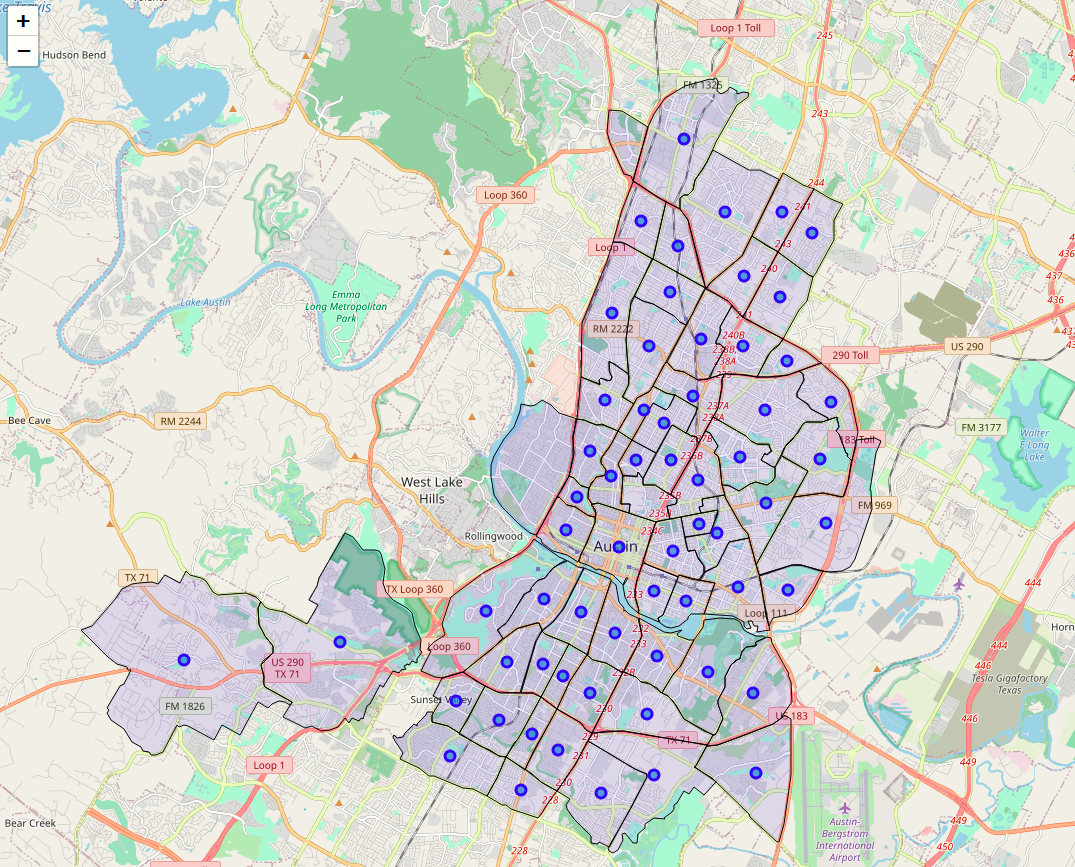

In [151]:
#Displaying the image screenshot from the html page in case folium map does not render in github
from IPython.display import Image
Image(filename = 'Neighborhood.png')

**2.3 Let's utilize the Foursquare API to explore and segment the neighborhoods.**

In [17]:
CLIENT_ID = '15YC4HE0KQAMUIY5QDM3ZHXP2FX1TMIDBZ3K0YGYYC0ADRZT' # my Foursquare ID
CLIENT_SECRET = 'YYBDTA2QHWGQKAKF551YNMIMG0BXJUJS5GSKCM5LKVDXSJLN' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [18]:
# Getting Neighborhood lat and long values

austin_data= df_merged

neigh_latitude = austin_data.loc[0, 'Latitude'] # neighborhood latitude value
neigh_longitude = austin_data.loc[0, 'Longitude'] # neighborhood longitude value

neigh_name = austin_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_latitude, 
                                                               neigh_longitude))

Latitude and longitude values of Allandale are 30.34030091175344, -97.74516940787922.


In [19]:
LIMIT = 100
radius = 750
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_latitude, 
    neigh_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=15YC4HE0KQAMUIY5QDM3ZHXP2FX1TMIDBZ3K0YGYYC0ADRZT&client_secret=YYBDTA2QHWGQKAKF551YNMIMG0BXJUJS5GSKCM5LKVDXSJLN&v=20180605&ll=30.34030091175344,-97.74516940787922&radius=750&limit=100'

In [20]:
results = requests.get(url,verify=False).json()
results

C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.foursquare.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


{'meta': {'code': 200, 'requestId': '5f4dfa87edbb5d0711146756'},
 'response': {'headerLocation': 'Allandale',
  'headerFullLocation': 'Allandale, Austin',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 30.34705091850345,
    'lng': -97.73736281708466},
   'sw': {'lat': 30.333550905003435, 'lng': -97.75297599867378}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '569c3717498e4c558d2263bc',
       'name': 'Barley Swine',
       'location': {'address': '6555 Burnet Rd',
        'lat': 30.341255716248515,
        'lng': -97.73845816423668,
        'labeledLatLngs': [{'label': 'display',
          'lat': 30.341255716248515,
          'lng': -97.73845816423668},
         {'label': 'entrance', 'lat': 30.34144, 'lng': -

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#venues = requests.get(url,verify=False).json()["response"]['groups'][0['items']
venues = results['response']['groups'][0]['items']    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


name               categories        lat        lng
0                 Barley Swine  New American Restaurant  30.341256 -97.738458
1                     Yard Bar                      Bar  30.342881 -97.738871
2  Lick Ice Creams Burnet Road           Ice Cream Shop  30.341143 -97.738408
3                 Bufalina Due              Pizza Place  30.341030 -97.738422
4            Three Little Pigs               Food Truck  30.340192 -97.738426

**2.4 Now Let's explore all the nighborhoods in Austin**|

In [22]:
# Function to get all nearby venues

def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url,verify=False).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

LIMIT=100

austin_venues = getNearbyVenues(names = austin_data['Neighborhood'],
                                   latitudes = austin_data['Latitude'],
                                   longitudes = austin_data['Longitude']
                                  )

Allandale
Barton Hills
Bouldin Creek
Brentwood
Central East Austin
Chestnut
Coronado Hills
Crestview
Dawson
Downtown
East Cesar Chavez
East Congress
East Oak Hill
Franklin Park
Galindo
Garrison Park
Georgian Acres
Govalle
Hancock
Heritage Hills
Highland
Holly
Hyde Park
Johnston Terrace
MLK
MLK 183
Mckinney
Montopolis
Mueller
North Austin
North Burnett
North Lamar
North Loop
North Shoal Creek
North University
Old Enfield
Old West Austin
Parker Lane
Pecan Springs-Springdale
Pleasant Valley
Riverside
Rosedale
Rosewood
South Lamar
South Manchaca
South River City
Southeast
St. Edwards
St. Johns
Sweetbriar
Triangle State
University Hills
Upper Boggy Creek
West Congress
West Oak Hill
West University
Westgate
Windsor Hills
Windsor Park
Windsor Road
Wooten
Zilker


In [24]:
print(austin_venues.shape)
austin_venues.head()

(2998, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Allandale              30.340301              -97.745169   
1    Allandale              30.340301              -97.745169   
2    Allandale              30.340301              -97.745169   
3    Allandale              30.340301              -97.745169   
4    Allandale              30.340301              -97.745169   

                         Venue  Venue Latitude  Venue Longitude  \
0                 Barley Swine       30.341256       -97.738458   
1                     Yard Bar       30.342881       -97.738871   
2  Lick Ice Creams Burnet Road       30.341143       -97.738408   
3                 Bufalina Due       30.341030       -97.738422   
4            Three Little Pigs       30.340192       -97.738426   

            Venue Category  
0  New American Restaurant  
1                      Bar  
2           Ice Cream Shop  
3              Pizza Place  
4               Food Truck

**2.5 Venue counts**

In [25]:
venue_counts= austin_venues.groupby('Neighborhood').count().reset_index()
venue_counts['Venue Counts'] = venue_counts['Venue']
venue_counts = venue_counts.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
venue_counts

Neighborhood  Venue Counts
0             Allandale            36
1          Barton Hills            10
2         Bouldin Creek           100
3             Brentwood            72
4   Central East Austin           100
..                  ...           ...
57        Windsor Hills            12
58         Windsor Park            24
59         Windsor Road            36
60               Wooten            82
61               Zilker           100

[62 rows x 2 columns]

In [26]:
print('There are {} uniques categories.'.format(len(austin_venues['Venue Category'].unique())))

There are 316 uniques categories.


**2.6 Analyzing each Neighborhood**

In [27]:
# One Hot Encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']],prefix="",prefix_sep="")

austin_onehot['Neighborhood'] = austin_venues['Neighborhood']

#Move the neighborhood column to the first column
list_column = austin_onehot.columns.tolist()
number_column = int(list_column.index('Neighborhood'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
austin_onehot = austin_onehot[list_column]

austin_onehot.head()


Neighborhood  ATM  Adult Boutique  Advertising Agency  African Restaurant  \
0    Allandale    0               0                   0                   0   
1    Allandale    0               0                   0                   0   
2    Allandale    0               0                   0                   0   
3    Allandale    0               0                   0                   0   
4    Allandale    0               0                   0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  ...  Video Game Store  Video Store  Vietnamese Restaurant  \
0            0  ...                 0            0                      0   
1            0  ...                 0            0                      0   
2            0  ...                 0            0                      0   
3            0  ...                 0            0                      0   
4            0  ...                 0            0                      0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0           0         0          0       0            0              0   
1           0         0          0       0            0              0   
2           0         0          0       0            0              0   
3           0         0          0       0            0              0   
4           0         0          0       0            0              0   

   Yoga Studio  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 317 columns]

In [28]:
austin_onehot.shape

(2998, 317)

In [30]:
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()

#Confirm that there should be 62 rows (62 neighborhoods)
print(austin_grouped.shape)
austin_grouped

(62, 317)


Neighborhood  ATM  Adult Boutique  Advertising Agency  \
0             Allandale  0.0             0.0                 0.0   
1          Barton Hills  0.0             0.0                 0.0   
2         Bouldin Creek  0.0             0.0                 0.0   
3             Brentwood  0.0             0.0                 0.0   
4   Central East Austin  0.0             0.0                 0.0   
..                  ...  ...             ...                 ...   
57        Windsor Hills  0.0             0.0                 0.0   
58         Windsor Park  0.0             0.0                 0.0   
59         Windsor Road  0.0             0.0                 0.0   
60               Wooten  0.0             0.0                 0.0   
61               Zilker  0.0             0.0                 0.0   

    African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                  0.0             0.000000      0.000000     0.0   
1                  0.0             0.000000      0.000000     0.0   
2                  0.0             0.000000      0.000000     0.0   
3                  0.0             0.027778      0.027778     0.0   
4                  0.0             0.000000      0.000000     0.0   
..                 ...                  ...           ...     ...   
57                 0.0             0.000000      0.000000     0.0   
58                 0.0             0.000000      0.000000     0.0   
59                 0.0             0.055556      0.000000     0.0   
60                 0.0             0.012195      0.000000     0.0   
61                 0.0             0.000000      0.000000     0.0   

    Argentinian Restaurant  Art Gallery  ...  Video Game Store  Video Store  \
0                     0.00         0.00  ...               0.0     0.027778   
1                     0.00         0.00  ...               0.0     0.000000   
2                     0.00         0.00  ...               0.0     0.000000   
3                     0.00         0.00  ...               0.0     0.013889   
4                     0.01         0.00  ...               0.0     0.000000   
..                     ...          ...  ...               ...          ...   
57                    0.00         0.00  ...               0.0     0.000000   
58                    0.00         0.00  ...               0.0     0.000000   
59                    0.00         0.00  ...               0.0     0.000000   
60                    0.00         0.00  ...               0.0     0.000000   
61                    0.00         0.03  ...               0.0     0.010000   

    Vietnamese Restaurant  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0                0.000000         0.0      0.00       0.00     0.0   
1                0.000000         0.0      0.00       0.00     0.0   
2                0.010000         0.0      0.00       0.00     0.0   
3                0.013889         0.0      0.00       0.00     0.0   
4                0.000000         0.0      0.00       0.01     0.0   
..                    ...         ...       ...        ...     ...   
57               0.000000         0.0      0.00       0.00     0.0   
58               0.000000         0.0      0.00       0.00     0.0   
59               0.000000         0.0      0.00       0.00     0.0   
60               0.036585         0.0      0.00       0.00     0.0   
61               0.010000         0.0      0.02       0.00     0.0   

    Wings Joint  Women's Store  Yoga Studio  
0           0.0           0.00     0.000000  
1           0.0           0.00     0.000000  
2           0.0           0.00     0.010000  
3           0.0           0.00     0.013889  
4           0.0           0.00     0.030000  
..          ...            ...          ...  
57          0.0           0.00     0.000000  
58          0.0           0.00     0.000000  
59          0.0           0.00     0.027778  
60          0.0           0.00     0.012195  
61          0.0           0.01     0.010000  

[62 rows x 317 columns

**Function to sort venues in descending order**

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
#Display top 10 venues in each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = austin_grouped['Neighborhood']

for ind in np.arange(austin_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

neigh_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0            Allandale            Food Truck           Pizza Place   
1         Barton Hills                  Pool                 Trail   
2        Bouldin Creek           Coffee Shop            Food Truck   
3            Brentwood          Burger Joint           Gas Station   
4  Central East Austin            Food Truck                   Bar   

  3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
0                   Gym       Mexican Restaurant          Ice Cream Shop   
1            Taco Place     Other Great Outdoors                     Spa   
2        Ice Cream Shop  New American Restaurant      Salon / Barbershop   
3    Mexican Restaurant              Coffee Shop  Thrift / Vintage Store   
4    Mexican Restaurant             Cocktail Bar             Coffee Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Bus Stop        Baseball Field              Beer Bar   
1        Scenic Lookout                   Gym           Coffee Shop   
2    Mexican Restaurant    Italian Restaurant                 Hotel   
3            Taco Place             Pet Store             Bookstore   
4              Dive Bar           Yoga Studio            Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0           Supermarket       Storage Facility  
1        Farmers Market                   Farm  
2       Thai Restaurant   Gym / Fitness Center  
3       Thai Restaurant            Pizza Place  
4         Grocery Store              BBQ Joint

**2.7 Clustering Neighborhoods**

Using K means clustering method for ananlysis. First we will cluster the neighborhoods into 3 clusters. Then we will analyze the K means with the elbow method to find the optimal k value for k means

In [33]:
# set number of clusters
kclusters = 3

austin_grouped_clustering = austin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

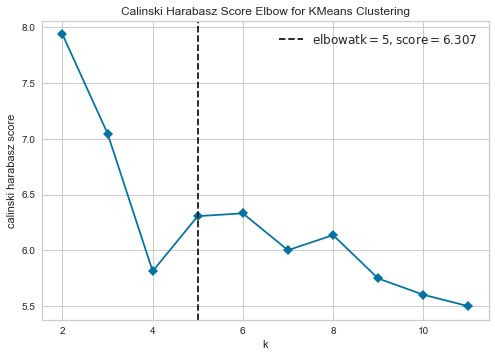

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [58]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(austin_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [59]:
# set the optimum clusters of neighborhoods as indicated above
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 0])

In [60]:
# add clustering labels
neighborhoods_venues_cluster = neigh_venues_sorted.copy()
neighborhoods_venues_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_cluster.head()

Cluster Labels         Neighborhood 1st Most Common Venue  \
0               0            Allandale            Food Truck   
1               0         Barton Hills                  Pool   
2               0        Bouldin Creek           Coffee Shop   
3               0            Brentwood          Burger Joint   
4               0  Central East Austin            Food Truck   

  2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0           Pizza Place                   Gym       Mexican Restaurant   
1                 Trail            Taco Place     Other Great Outdoors   
2            Food Truck        Ice Cream Shop  New American Restaurant   
3           Gas Station    Mexican Restaurant              Coffee Shop   
4                   Bar    Mexican Restaurant             Cocktail Bar   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0          Ice Cream Shop              Bus Stop        Baseball Field   
1                     Spa        Scenic Lookout                   Gym   
2      Salon / Barbershop    Mexican Restaurant    Italian Restaurant   
3  Thrift / Vintage Store            Taco Place             Pet Store   
4             Coffee Shop              Dive Bar           Yoga Studio   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0              Beer Bar           Supermarket       Storage Facility  
1           Coffee Shop        Farmers Market                   Farm  
2                 Hotel       Thai Restaurant   Gym / Fitness Center  
3             Bookstore       Thai Restaurant            Pizza Place  
4            Restaurant         Grocery Store              BBQ Joint

In [61]:
# add geographic coordinates back for each neighborhood
merged_aus = df_merged
merged_aus = merged_aus.join(neighborhoods_venues_cluster.set_index('Neighborhood'), on = 'Neighborhood')

print(merged_aus.shape)
merged_aus.head()

(62, 15)


Neighborhood Median-HousePrice   Latitude  Longitude  \
0            Allandale            621300  30.340301 -97.745169   
1         Barton Hills            690100  30.252021 -97.788367   
2        Bouldin Creek            710300  30.251705 -97.755626   
3            Brentwood            493800  30.330625 -97.732451   
4  Central East Austin            483800  30.269742 -97.724153   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0            Food Truck           Pizza Place   
1               0                  Pool                 Trail   
2               0           Coffee Shop            Food Truck   
3               0          Burger Joint           Gas Station   
4               0            Food Truck                   Bar   

  3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
0                   Gym       Mexican Restaurant          Ice Cream Shop   
1            Taco Place     Other Great Outdoors                     Spa   
2        Ice Cream Shop  New American Restaurant      Salon / Barbershop   
3    Mexican Restaurant              Coffee Shop  Thrift / Vintage Store   
4    Mexican Restaurant             Cocktail Bar             Coffee Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Bus Stop        Baseball Field              Beer Bar   
1        Scenic Lookout                   Gym           Coffee Shop   
2    Mexican Restaurant    Italian Restaurant                 Hotel   
3            Taco Place             Pet Store             Bookstore   
4              Dive Bar           Yoga Studio            Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0           Supermarket       Storage Facility  
1        Farmers Market                   Farm  
2       Thai Restaurant   Gym / Fitness Center  
3       Thai Restaurant            Pizza Place  
4         Grocery Store              BBQ Joint

We can also estimate the number of **1st Most Common Venue** in each cluster.Thus, we can create a data frame which may help us to find proper label names for each cluster.

In [62]:
count_venue = merged_aus
count_venue = count_venue.drop(['Neighborhood','Median-HousePrice', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')
count_venue

Cluster Labels                     1st Most Common Venue  Counts
0                0                       American Restaurant       1
1                0                              Burger Joint       1
2                0                                      Café       1
3                0                               Coffee Shop       5
4                0                            Cosmetics Shop       1
5                0                            Discount Store       1
6                0                      Fast Food Restaurant       1
7                0                                Food Truck       5
8                0                                       Gym       1
9                0                                     Hotel       4
10               0                        Italian Restaurant       1
11               0                        Mexican Restaurant       1
12               0                                      Park       2
13               0                                      Pool       1
14               0                       Rental Car Location       1
15               0                            Sandwich Place       2
16               0                       Sporting Goods Shop       1
17               1                       Sporting Goods Shop       1
18               2                       American Restaurant       1
19               2                               Art Gallery       1
20               2                                       Bar       1
21               2                            Discount Store       1
22               2                              Home Service       1
23               2                                     Hotel       2
24               2                         Korean Restaurant       1
25               2                                 Laser Tag       1
26               2                        Mexican Restaurant      11
27               2                                     Motel       1
28               2                         Outdoor Sculpture       1
29               2                               Pizza Place       2
30               2  Residential Building (Apartment / Condo)       1
31               2                            Sandwich Place       1
32               2                                   Theater       2
33               2                               Video Store       1
34               3                                      Park       1
35               4                                       Gym       1

In [63]:
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(cv_cluster)

1st Most Common Venue  American Restaurant  Art Gallery  Bar  Burger Joint  \
0                                        1            0    0             1   
1                                        0            0    0             0   
2                                        1            1    1             0   
3                                        0            0    0             0   
4                                        0            0    0             0   

1st Most Common Venue  Café  Coffee Shop  Cosmetics Shop  Discount Store  \
0                         1            5               1               1   
1                         0            0               0               0   
2                         0            0               0               1   
3                         0            0               0               0   
4                         0            0               0               0   

1st Most Common Venue  Fast Food Restaurant  Food Truck  Gym  Home Service  \
0                                         1           5    1             0   
1                                         0           0    0             0   
2                                         0           0    0             1   
3                                         0           0    0             0   
4                                         0           0    1             0   

1st Most Common Venue  Hotel  Italian Restaurant  Korean Restaurant  \
0                          4                   1                  0   
1                          0                   0                  0   
2                          2                   0                  1   
3                          0                   0                  0   
4                          0                   0                  0   

1st Most Common Venue  Laser Tag  Mexican Restaurant  Motel  \
0                              0                   1      0   
1                              0                   0      0   
2                              1                  11      1   
3                              0                   0      0   
4                              0                   0      0   

1st Most Common Venue  Outdoor Sculpture  Park  Pizza Place  Pool  \
0                                      0     2            0     1   
1                                      0     0            0     0   
2                                      1     0            2     0   
3                                      0     1            0     0   
4                                      0     0            0     0   

1st Most Common Venue  Rental Car Location  \
0                                        1   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

1st Most Common Venue  Residential Building (Apartment / Condo)  \
0                                                             0   
1                                                             0   
2                                                             1   
3                                                             0   
4                                                             0   

1st Most Common Venue  Sandwich Place  Sporting Goods Shop  Theater  \
0                                   2                    1        0   
1                                   0                    1        0   
2                                   1                    0        2   
3                                   0                    0        0   
4                                   0                    0        0   

1st Most Common Venue  Video Store  
0                                0  
1                                0  
2                                1  
3                                0  
4                                0

When we examine above data we can label each cluster as follows:
* Cluster 0 : "Food venues and misc social venues"
* Cluster 1 : "Sporting Goods"
* Cluster 2 : "Stores and residential venues"
* Cluster 3 : "Park"
* Cluster 4 : "Gym"

We can now assign those new labels to existing label of clusters:

In [65]:
Cluster_labels = {'Clusters': [0,1,2,3,4], 'Labels': ["Food venues and misc social venues","Sporting Goods","Stores and residential venues","Park","Gym"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

Clusters                              Labels
0         0  Food venues and misc social venues
1         1                      Sporting Goods
2         2       Stores and residential venues
3         3                                Park
4         4                                 Gym

In [66]:
data_process = merged_aus.sort_values('Median-HousePrice').reset_index(drop=True)

#data_process=data_process.drop(data_process.columns.difference(['Neighborhood',
                                                                #'Median-HousePrice',
                                                                #'Cluster Labels']), axis=1)
data_process.head()

Neighborhood Median-HousePrice   Latitude  Longitude  Cluster Labels  \
0    North Burnett            187600  30.391839 -97.720392               0   
1    Franklin Park            237500  30.198014 -97.748727               2   
2  Pleasant Valley            239400  30.233975 -97.711968               0   
3         Mckinney            246900  30.203195 -97.730568               1   
4        Southeast            259300  30.203940 -97.695715               4   

  1st Most Common Venue       2nd Most Common Venue 3rd Most Common Venue  \
0                 Hotel                     Brewery  Fast Food Restaurant   
1           Video Store          Miscellaneous Shop     Convenience Store   
2        Cosmetics Shop              Discount Store           Bus Station   
3   Sporting Goods Shop  Construction & Landscaping        Sandwich Place   
4                   Gym                        Café             Disc Golf   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Food Truck                   Bar           Coffee Shop   
1    Mexican Restaurant            Food Truck          Intersection   
2          Liquor Store                  Pool  Gym / Fitness Center   
3                  Farm           Escape Room  Ethiopian Restaurant   
4                Office           Coffee Shop                  Farm   

  7th Most Common Venue   8th Most Common Venue 9th Most Common Venue  \
0        Sandwich Place  Furniture / Home Store                   Spa   
1       Automotive Shop                    Park        Rental Service   
2             Pool Hall        Department Store        Sandwich Place   
3         Event Service             Event Space            Eye Doctor   
4           Event Space              Eye Doctor               Factory   

  10th Most Common Venue  
0            Salad Place  
1            Yoga Studio  
2                   Café  
3                Factory  
4     Falafel Restaurant

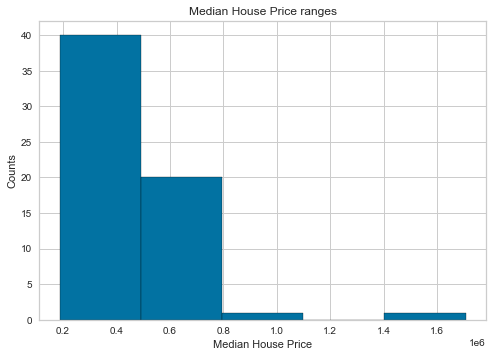

In [67]:
#Plotting a frequency plot for House sales in different ranges
plt.hist(data_process['Median-HousePrice'], bins=5,alpha=1, histtype='bar', ec='black')
plt.gca().set(title='Median House Price ranges', xlabel='Median House Price',ylabel='Counts');

#### From the above histogram, we can define the Median House Price ranges as below:

* '<' 200,000 USD : "Very Low"
* 200,000-400,000 USD : "Low"
* 400,000-600,000 USD : "Medium"
* 600,000-800,000 USD : "Medium-High"
* 800,000-1,000,000 USD : "High"
* '>' 1,000,000 USD : "Very High"


In [68]:
ranges = []
for i in range(0,len(data_process)):
    if (data_process['Median-HousePrice'][i] < 200000):
        ranges.append("Very Low")
    elif (data_process['Median-HousePrice'][i] >= 200000 and data_process['Median-HousePrice'][i] < 400000):
        ranges.append("Low")
    elif (data_process['Median-HousePrice'][i] >= 400000 and data_process['Median-HousePrice'][i] < 600000):
        ranges.append("Medium")
    elif (data_process['Median-HousePrice'][i] >= 600000 and data_process['Median-HousePrice'][i] < 800000):
        ranges.append("High")
    else:
        ranges.append("Very High")   

data_process['Ranges_labels'] = ranges

data_process=data_process.reindex(['Neighborhood','Median-HousePrice','Cluster Labels','Ranges_labels'], axis=1)

data_process.head()

Neighborhood Median-HousePrice  Cluster Labels Ranges_labels
0    North Burnett            187600               0      Very Low
1    Franklin Park            237500               2           Low
2  Pleasant Valley            239400               0           Low
3         Mckinney            246900               1           Low
4        Southeast            259300               4           Low

We can now show the top three venues for each neighborhood on the map. To begin with let us group each neighborhood by the count and type of each of the top 3 venues

In [70]:
top3 = austin_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)

top3['Venue text'] = top3[['Counts','Venue Category']].apply(lambda x : '{} {}'.format(x[0],x[1]), axis=1)
top3 = top3.groupby(['Neighborhood'])['Venue text'].apply(", ".join).reset_index()
top3.head()

Neighborhood                                     Venue text
0            Allandale      3 Food Truck, 2 Gym, 2 Mexican Restaurant
1         Barton Hills                 2 Pool, 2 Trail, 1 Coffee Shop
2        Bouldin Creek  6 Coffee Shop, 6 Food Truck, 4 Ice Cream Shop
3            Brentwood   5 Burger Joint, 3 Coffee Shop, 3 Gas Station
4  Central East Austin     14 Food Truck, 9 Bar, 6 Mexican Restaurant

## **3. Results**
**3.1. Main table with results**

In [123]:
import numpy as np

#data_austin_processed = merged_aus.sort_values('Median-HousePrice').reset_index(drop=True)

result = pd.merge(merged_aus, 
                    top3[['Neighborhood', 'Venue text']],
                    left_on = 'Neighborhood',
                    right_on = 'Neighborhood',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Neighborhood', 'Ranges_labels']],
                    left_on = 'Neighborhood',
                    right_on = 'Neighborhood',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(10)

Neighborhood Median-HousePrice   Latitude  Longitude  \
0            Allandale            621300  30.340301 -97.745169   
1         Barton Hills            690100  30.252021 -97.788367   
2        Bouldin Creek            710300  30.251705 -97.755626   
3            Brentwood            493800  30.330625 -97.732451   
4  Central East Austin            483800  30.269742 -97.724153   
5             Chestnut            458100  30.277860 -97.715048   
6       Coronado Hills            270100  30.326101 -97.685003   
7            Crestview            490100  30.346578 -97.725062   
8               Dawson            533100  30.232690 -97.761790   
9             Downtown            515100  30.271005 -97.742758   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0            Food Truck           Pizza Place   
1               0                  Pool                 Trail   
2               0           Coffee Shop            Food Truck   
3               0          Burger Joint           Gas Station   
4               0            Food Truck                   Bar   
5               2                   Bar               Theater   
6               2    Mexican Restaurant           Gas Station   
7               2    Mexican Restaurant                   Gym   
8               2    Mexican Restaurant         Grocery Store   
9               0                 Hotel           Coffee Shop   

    3rd Most Common Venue    4th Most Common Venue   5th Most Common Venue  \
0                     Gym       Mexican Restaurant          Ice Cream Shop   
1              Taco Place     Other Great Outdoors                     Spa   
2          Ice Cream Shop  New American Restaurant      Salon / Barbershop   
3      Mexican Restaurant              Coffee Shop  Thrift / Vintage Store   
4      Mexican Restaurant             Cocktail Bar             Coffee Shop   
5            Cocktail Bar        Convenience Store                    Park   
6           Grocery Store        Convenience Store          Sandwich Place   
7  Furniture / Home Store              Pizza Place    Gym / Fitness Center   
8              Food Truck                BBQ Joint             Coffee Shop   
9            Cocktail Bar                   Lounge                     Bar   

  6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
0              Bus Stop        Baseball Field                 Beer Bar   
1        Scenic Lookout                   Gym              Coffee Shop   
2    Mexican Restaurant    Italian Restaurant                    Hotel   
3            Taco Place             Pet Store                Bookstore   
4              Dive Bar           Yoga Studio               Restaurant   
5           Coffee Shop            Taco Place           Sandwich Place   
6  Fast Food Restaurant      Asian Restaurant  Comfort Food Restaurant   
7                Bakery            Smoke Shop                 Bus Stop   
8          Burger Joint            Smoke Shop                      Gym   
9             Nightclub             Hotel Bar              Yoga Studio   

  9th Most Common Venue 10th Most Common Venue  \
0           Supermarket       Storage Facility   
1        Farmers Market                   Farm   
2       Thai Restaurant   Gym / Fitness Center   
3       Thai Restaurant            Pizza Place   
4         Grocery Store              BBQ Joint   
5           Art Gallery             Food Truck   
6    Seafood Restaurant          Smoothie Shop   
7        Shipping Store           Burger Joint   
8            Taco Place     Athletics & Sports   
9             Speakeasy     Seafood Restaurant   

                                          Venue text  \
0          3 Food Truck, 2 Gym, 2 Mexican Restaurant   
1                     2 Pool, 2 Trail, 1 Coffee Shop   
2      6 Coffee Shop, 6 Food Truck, 4 Ice Cream Shop   
3       5 Burger Joint, 3 Coffee Shop, 3 Gas Station   
4         14 Food Truck, 9 Bar, 6 Mexican Restaurant   
5     

**3.2. Examine each cluster**

**Cluster1**

In [132]:
result.loc[result['Cluster Labels'] == 0, result.columns[[0,1,4] + list(range(5, result.shape[1]))]]

Neighborhood Median-HousePrice  Cluster Labels  \
0             Allandale            621300               0   
1          Barton Hills            690100               0   
2         Bouldin Creek            710300               0   
3             Brentwood            493800               0   
4   Central East Austin            483800               0   
9              Downtown            515100               0   
10    East Cesar Chavez            559100               0   
11        East Congress            342600               0   
12        East Oak Hill            507500               0   
16       Georgian Acres            268700               0   
25              MLK 183            342000               0   
28              Mueller            589900               0   
30        North Burnett            187600               0   
31          North Lamar            265000               0   
32           North Loop            441000               0   
33    North Shoal Creek            405600               0   
34     North University            398700               0   
36      Old West Austin            794900               0   
39      Pleasant Valley            239400               0   
41             Rosedale            680100               0   
43          South Lamar            521300               0   
45     South River City            713300               0   
47          St. Edwards            505200               0   
50       Triangle State            515000               0   
55      West University            311800               0   
56             Westgate            450500               0   
57        Windsor Hills            301100               0   
59         Windsor Road           1706200               0   
60               Wooten            400900               0   
61               Zilker            749600               0   

   1st Most Common Venue   2nd Most Common Venue   3rd Most Common Venue  \
0             Food Truck             Pizza Place                     Gym   
1                   Pool                   Trail              Taco Place   
2            Coffee Shop              Food Truck          Ice Cream Shop   
3           Burger Joint             Gas Station      Mexican Restaurant   
4             Food Truck                     Bar      Mexican Restaurant   
9                  Hotel             Coffee Shop            Cocktail Bar   
10            Food Truck                     Bar      Mexican Restaurant   
11                 Hotel              Food Truck             Coffee Shop   
12        Sandwich Place      Italian Restaurant    Gym / Fitness Center   
16                 Hotel    Fast Food Restaurant     Sporting Goods Shop   
25                   Gym                 Brewery          Sandwich Place   
28                  Park              Food Truck             Coffee Shop   
30                 Hotel                 Brewery    Fast Food Restaurant   
31        Discount Store   Vietnamese Restaurant                    Bank   
32           Coffee Shop             Pizza Place          Breakfast Spot   
33   Sporting Goods Shop                     Gym  Furniture / Home Store   
34        Sandwich Place             Pizza Place            Burger Joint   
36   American Restaurant             Yoga Studio                     Gym   
39        Cosmetics Shop          Discount Store             Bus Station   
41           Coffee Shop      Mexican Restaurant                     Gym   
43  Fast Food Restaurant            Burger Joint              Food Truck   
45    Italian Restaurant              Food Truck             Pizza Place   
47           Coffee Shop              Food Truck                   Hotel   
50            Food Truck                    Park      Mexican Restaurant   
55            Food Truck             Coffee Shop          Sandwich Place   
56                  Café             Gas Station              Food Truck   
57   Rental Car Location  Furniture / Home Store       Electronics 

**Cluster2**

In [135]:
result.loc[result['Cluster Labels'] == 1, result.columns[[0,1,4] + list(range(5, result.shape[1]))]]

Neighborhood Median-HousePrice  Cluster Labels 1st Most Common Venue  \
26     Mckinney            246900               1   Sporting Goods Shop   

         2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
26  Construction & Landscaping        Sandwich Place                  Farm   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
26           Escape Room  Ethiopian Restaurant         Event Service   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
26           Event Space            Eye Doctor                Factory   

                                           Venue text          Labels  \
26  2 Sporting Goods Shop, 1 Construction & Landsc...  Sporting Goods   

   Ranges_labels  
26           Low

**Cluster3**

In [134]:
result.loc[result['Cluster Labels'] == 2, result.columns[[0,1,4] + list(range(5, result.shape[1]))]]

Neighborhood Median-HousePrice  Cluster Labels  \
5                   Chestnut            458100               2   
6             Coronado Hills            270100               2   
7                  Crestview            490100               2   
8                     Dawson            533100               2   
13             Franklin Park            237500               2   
14                   Galindo            549300               2   
15             Garrison Park            361400               2   
17                   Govalle            427000               2   
18                   Hancock            541700               2   
19            Heritage Hills            355700               2   
20                  Highland            392100               2   
21                     Holly            494900               2   
22                 Hyde Park            586400               2   
23          Johnston Terrace            344400               2   
24                       MLK            400400               2   
27                Montopolis            292300               2   
29              North Austin            332200               2   
35               Old Enfield           1010500               2   
37               Parker Lane            351700               2   
38  Pecan Springs-Springdale            385400               2   
40                 Riverside            405200               2   
42                  Rosewood            423500               2   
44            South Manchaca            379000               2   
48                 St. Johns            289500               2   
49                Sweetbriar            301100               2   
51          University Hills            415900               2   
52         Upper Boggy Creek            474700               2   
53             West Congress            357000               2   
58              Windsor Park            403600               2   

                       1st Most Common Venue  2nd Most Common Venue  \
5                                        Bar                Theater   
6                         Mexican Restaurant            Gas Station   
7                         Mexican Restaurant                    Gym   
8                         Mexican Restaurant          Grocery Store   
13                               Video Store     Miscellaneous Shop   
14  Residential Building (Apartment / Condo)     Mexican Restaurant   
15                               Pizza Place     Mexican Restaurant   
17                               Art Gallery                Brewery   
18                            Sandwich Place          Grocery Store   
19                              Home Service                   Park   
20                         Korean Restaurant     Mexican Restaurant   
21                        Mexican Restaurant            Pizza Place   
22                        Mexican Restaurant          Deli / Bodega   
23                        Mexican Restaurant            Art Gallery   
24                         Outdoor Sculpture                   Park   
27                                     Hotel     Mexican Restaurant   
29                        Mexican Restaurant         Ice Cream Shop   
35                       American Restaurant                   Park   
37                        Mexican Restaurant  Vietnamese Restaurant   
38                                     Motel         Discount Store   
40                        Mexican Restaurant             Food Truck   
42                                   Theater                   Park   
44                                 Laser Tag            Video Store   
48                                     Hotel     Mexican Restaurant   
49                        Mexican Restaurant   Fast Food Restaurant   
51                            Discount Store            Pizza Place   
52                                   Theater             Taco Place   
53                        Mexican Restaurant   

**Cluster4**

In [136]:
result.loc[result['Cluster Labels'] == 3, result.columns[[0,1,4] + list(range(5, result.shape[1]))]]

Neighborhood Median-HousePrice  Cluster Labels 1st Most Common Venue  \
54  West Oak Hill            449100               3                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
54         Event Service                Resort           Video Store   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
54          Intersection           Yoga Studio                  Farm   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
54  Ethiopian Restaurant           Event Space             Eye Doctor   

                                 Venue text Labels Ranges_labels  
54  1 Event Service, 1 Intersection, 1 Park   Park        Medium

**Cluster5**

In [137]:
result.loc[result['Cluster Labels'] == 4, result.columns[[0,1,4] + list(range(5, result.shape[1]))]]

Neighborhood Median-HousePrice  Cluster Labels 1st Most Common Venue  \
46    Southeast            259300               4                   Gym   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
46                  Café             Disc Golf                Office   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
46           Coffee Shop                  Farm           Event Space   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
46            Eye Doctor               Factory     Falafel Restaurant   

                      Venue text Labels Ranges_labels  
46  2 Café, 2 Gym, 1 Coffee Shop    Gym           Low

**3.3. Map of Cluster Results**

In [138]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, ranges, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['Labels'], result['Venue text'], result['Cluster Labels'], result['Ranges_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(ranges), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [146]:
map_clusters.save('ClusterResults.html')

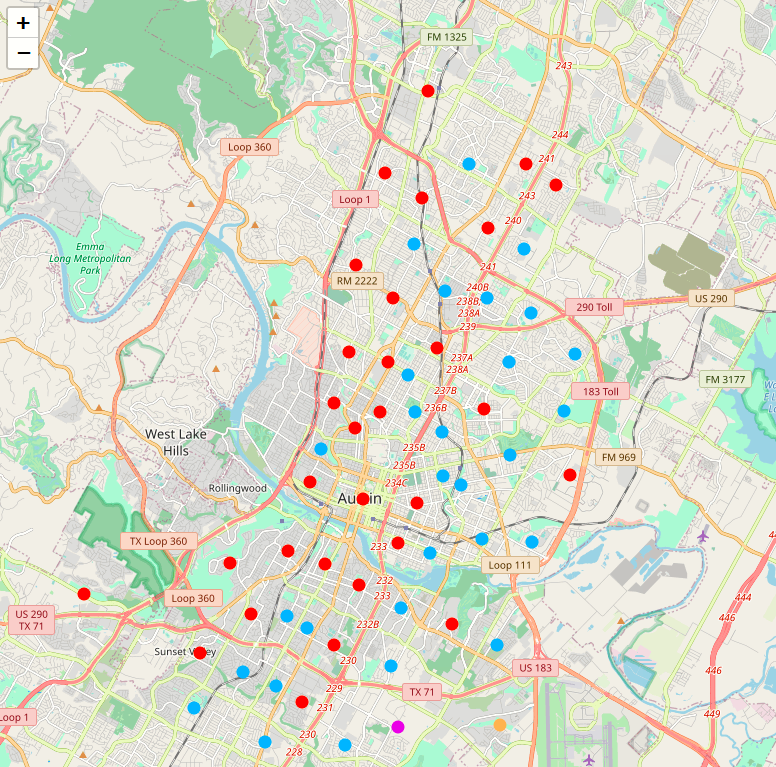

In [147]:
#Displaying the image screenshot from the html page in case folium map does not render in github
from IPython.display import Image
Image(filename = 'ClusterResults.png')

**3.4. Map of Housing Sales Prices**

In the introduction the aim of this project was defined as visualizing the Median House Prices for each Austin Neighborhood. We will do this using a choropleth style map.
For this let us import the geojson file containing Austin Neighborhood boundaries again.

In [139]:
austin_geo = r'Boundaries_ Austin Neighborhood Planning Areas.geojson'

print("Geojson file imported")

Geojson file imported


Let us now create a choropleth map with the following data

1.Neighborhood
2.Cluster Name
3.Housing Price Ranges
4.Top 3 venues

In [144]:
map_neighborhood = folium.Map(location = [latitude, longitude], zoom_start = 11)

folium.Choropleth(
    geo_data = austin_geo, 
    data = result, 
    columns = ['Neighborhood', 'Median-HousePrice'], 
    key_on = 'feature.properties.label', 
    fill_color = 'YlOrRd',
    nan_fill_color='White',
    fill_opacity = 0.8, 
    line_opacity = 0.2, 
    legend_name = 'House Prices in Austin',
    highlight=True
).add_to(map_neighborhood)

markers_colors = []
for lat, lon, poi, cluster, ranges, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['Labels'], result['Venue text'], result['Cluster Labels'], result['Ranges_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(ranges), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_neighborhood)

map_neighborhood

In [148]:
map_neighborhood.save('HousingPrices.html')

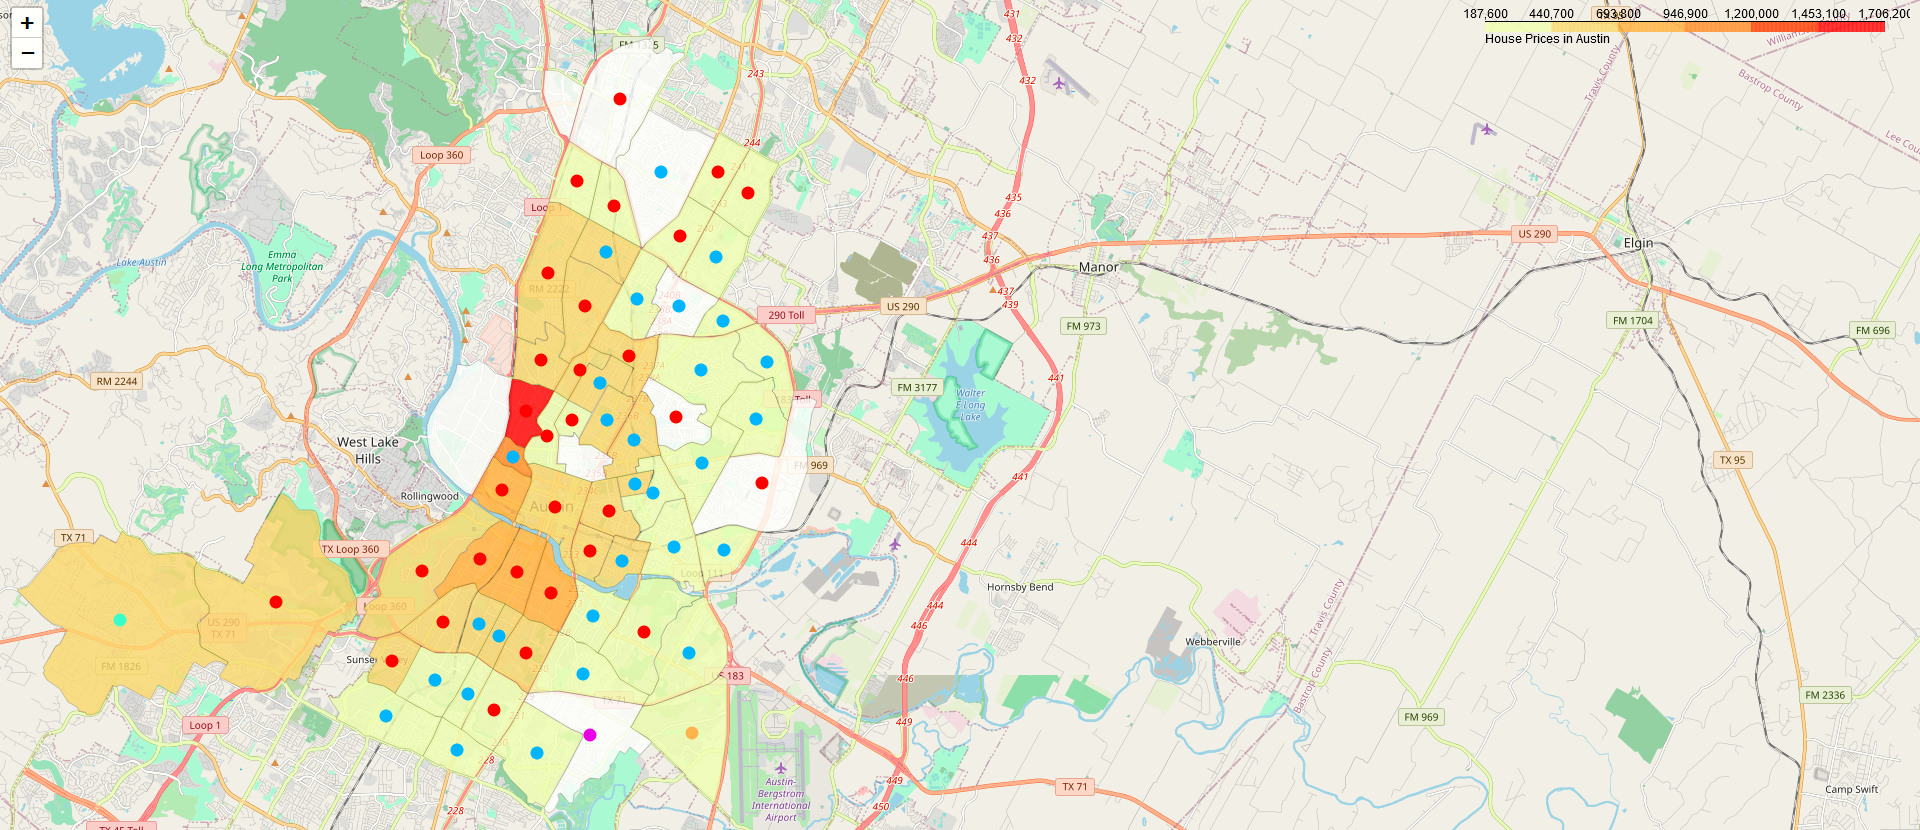

In [149]:
#Displaying the image screenshot from the html page in case folium map does not render in github
from IPython.display import Image
Image(filename = 'HousingPrices.png')

There were certain mismatches from the geo json file earlier that resulted in Nan Values. We fixed these during data pre-processing for data analysis earlier. I am using **white** as the fill color to deal with these values for the polygon overlay.

## **4. Discussion**

Austin is one of the fastest growing cities in the United States with a burgeoning population. As such the population densities across the various neighborhoods can vary. Due to the high complexity several different clustering or classification methods can be used. 

In my study I used the K-means clustering algorithm. On testing for the Elbow using the Calinski Harabasz Method we can arrive at an optimal k value of 5. This study was conducted using open source datasets that may be incomplete or outdated. Furthermore, due to certain mismatches in both the data sets a small number of neighborhoods were excluded from analysis. For more accurate results a more recent dataset can be used which will result in more accurate results. Also, more details on each neighborhood can be explored.

We also exlpored the median house prices for each neighborhood in order to further analyze which neighborhood would offer a good combination of affordability as well as being close to social venues which would contibute to the attractiveness for any potential buyer. In future studies this data can be sourced from more recent data.

I ended the study by examining the neighborhoods in each cluster and plottting the results on a map of Austin. This depicts the venues in each neighborhood as well as the approximate cost of purchasing a house. This can assist both future investors and future residents.

## **5. Conclusion**

As more people move to Austin,TX the city is experiencing a real estate boom along with a rapidly expanding social scene. Investors, residents and maybe even city planning officials can benefit greatly from access to results from data analysis.

## **5. References:**

[1]. Austin, Texas, Wikipedia. Retrieved from: https://en.wikipedia.org/wiki/Austin,_Texas<br>
[2] Texas- Hottest Real Estate Market in 2020? Retrieved from: https://www.marketcurrentswealthnet.com/features/texas-hottest-real-estate-market-in-2020/<br>
[3]. Boundaries: Austin Neighborhood Planning Areas, data.austintexas.gov, the official City of Austin open data portal. Retrieved from:
https://data.austintexas.gov/dataset/Boundaries-Austin-Neighborhood-Planning-Areas/nz5f-3t2e/data<br>
[4]. Austin Home Prices & Values,Zillow. Retrieved from
https://www.zillow.com/austin-tx/home-values/<br>
[5] Queried venue data for each neighbood using the foursquare API, FourSquare API. Retrieved from:
https://developer.foursquare.com/docs/api-reference/venues/explore/<br>